# Relevant Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

# Week 1

In [2]:
# Generate datapoints
l = 100
dim = 1
d = np.random.rand(l, dim) * 20
noise = 1 # sigma^2_y
def augment_d(d): # Augments dataset with an intercept column
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T
eps = np.random.randn(l) * np.sqrt(noise)

true_weights = np.array([-9, 15]) # Underlying data-generating weights
y = augment_d(d) @ true_weights + eps

In [30]:
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = cov.shape[-1]
    x_mu = x - mu
    _, log_det = np.linalg.slogdet(cov)
    cov_inv = np.linalg.inv(cov)
    prod = x_mu.T @ cov_inv @ x_mu
    log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob

In [24]:
mu_prior = np.array([19, 5])
cov_prior = np.array([[20, 0.3], [0.3, -3]]) * 20

In [81]:
def analytical_posterior_pdf(theta, d, y): # Compute pdf
    l = len(d)
    mu = mu_prior + cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ (y - d @ mu_prior)
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ d @ cov_prior
    return np.exp(stable_multivariate_gaussian_logpdf(theta, mu, cov))
def analytical_posterior_params(d, y, mu_prior=mu_prior, cov_prior=cov_prior): # Get parameters of pdf
    l = len(d)
    mu = mu_prior + cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ (y - d @ mu_prior)
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ d @ cov_prior
    return mu, cov


In [26]:
true_weights

array([-9, 15])

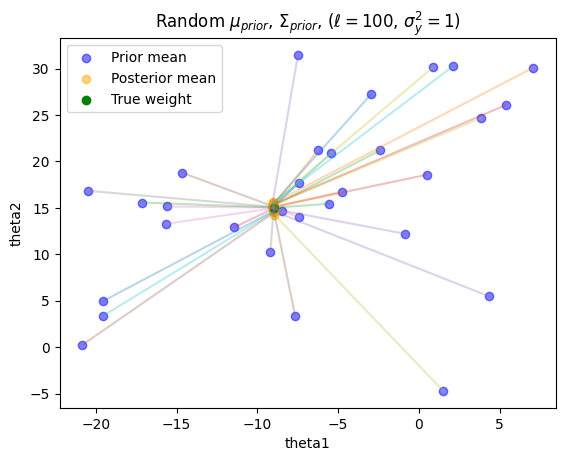

In [31]:
N = 30
mu_prior_samples = (np.random.randn(N, 2))*10 + true_weights
cov_prior_samples = np.tile(np.eye(2), (N, 1, 1))
mus = np.array([analytical_posterior_params(augment_d(d), y, mu_prior=mu_prior, cov_prior=cov_prior)[0] for mu_prior, cov_prior in zip(mu_prior_samples, cov_prior_samples)])

#plt.scatter([(eigen[0], eigen[1]) for eigen in np.linalg.eigen(covs)])
for prior, posterior in zip(mu_prior_samples, mus):
    plt.plot([prior[0], posterior[0]], [prior[1], posterior[1]], alpha=0.3)
plt.scatter(mu_prior_samples[:, 0], mu_prior_samples[:, 1], color="blue", label="Prior mean", alpha=0.5)
plt.scatter(mus[:, 0], mus[:, 1], color="orange", label="Posterior mean", alpha=0.5)
plt.scatter(true_weights[0], true_weights[1], color="green", label="True weight")
#plt.xlim(-40, 10)
#plt.ylim(-10,40)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("Random $\mu_{prior}$, $\Sigma_{prior}$, ($\ell = %d$, $\sigma^2_y = %d$)" % (l, noise))
plt.legend()

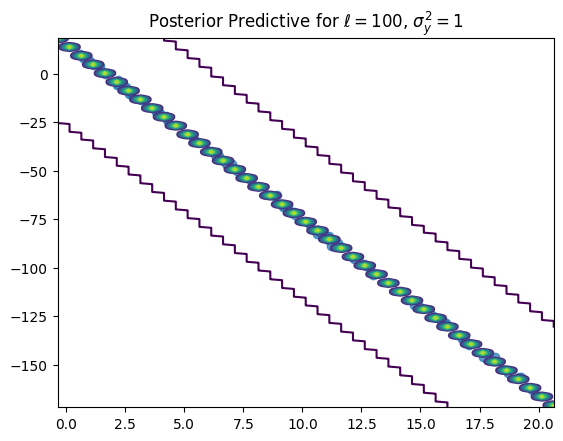

In [8]:
def plot_predictive(mean, cov, x, y):
    # Define the grid for the contour plot
    plt.scatter(x, y, alpha=0.7)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    x_grid, y_grid = numpy.mgrid[xmin:xmax:.5, ymin:ymax:.5]

    pos = np.empty(x_grid.shape + (2,))
    pos[:, :, 0] = x_grid
    pos[:, :, 1] = y_grid
    #print(np.dstack((x_grid, y_grid)))
    z = []

    # Create a multivariate normal distribution
    for row in np.dstack((x_grid, y_grid)):
        row_x = augment_d(np.array([row[:, 0]]).T)
        row_y = np.array([row[:, 1]])
        #row_z = scipy.stats.multivariate_normal.pdf(row_y, row_x @ mean, np.var(y)*np.eye(len(row_x)) + row_x @ cov @ row_x.T)
        #print(row_z)
        row_z = []
        for [x_p, y_p] in row:
            #p = np.array([x_var, y_var])
            x_p = np.array([x_p, 1])
            rv = scipy.stats.multivariate_normal(x_p.T @ mean, noise + x_p.T @ cov @ x_p)
            # Evaluate the probability density function on the grid
            row_z.append(rv.pdf(y_p))
        z.append(np.array(row_z))
    z = np.array(z).reshape(x_grid.shape)
    # Plot the scatter plot
    plt.contour(x_grid, y_grid, z)
    ones = np.ones((len(np.linspace(xmin, xmax)), 1))
    x_aug = np.concatenate((np.linspace(xmin, xmax).reshape(len(ones), 1), ones), axis=1)
    #plt.plot(np.linspace(xmin, xmax).reshape(len(ones), 1), f(x_aug, mean), c='purple', label="Mean Parameter Estimate")
    #plt.legend()
    plt.title("Posterior Predictive for $\ell = %d$, $\sigma^2_y = %d$" % (l, noise))
    plt.show()
params = analytical_posterior_params(augment_d(d), y)
plot_predictive(params[0], params[1], d, y)

# Week 2

In [9]:
def mutual_information(d):
    l = len(d)
    M = 2
    N = 5
    samples = []
    thetas = np.random.multivariate_normal(mu_prior, cov_prior, size=N)
    for theta in thetas:
        ys = ((np.tile(augment_d(d), (M, 1, 1)) @ theta).T + (noise * np.eye(len(d))) @ np.random.randn(len(d), M)).T
        for y in ys:
            mu_post, cov_post = analytical_posterior_params(augment_d(d), y, mu_prior=mu_prior, cov_prior=cov_prior)
            val = stable_multivariate_gaussian_logpdf(theta, mu_post, cov_post) - 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_prior))
            samples.append(val)
    return 1/(N * M) * np.sum(samples)

In [10]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=False):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        if not callback(x, g):
            break
    return x


In [11]:
def decode_d(encoded_d, dim=1):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

In [12]:
def optimize(g, d0, alpha, beta, c, iterations, callback=lambda _: True):
    d = d0
    for i in trange(int(iterations)):
        d = d - alpha / (10**c + i * 10**(-beta)) * g(d)
        if not callback(d):
            break
    return d

In [32]:
mu_prior = np.array([180, -77, 90])
cov_prior = np.eye(3)
d0 = np.array([[0,0] for _ in range(10)])
dis = []
dis.append(d0)
mis = []
def callback(di):
    dis.append(decode_d(di, dim=2))
    return True

def g(di):
    di = decode_d(di, dim=2)
    gra = grad(lambda di: -mutual_information(di))(di)
    mis.append(mutual_information(di))
    reg_term = 1e-2 * 2 * encode_d(di) # L2 norm gradient
    return encode_d(gra)
optimize(g, encode_d(d0), 1, 2, 0, 1e3, callback=callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, 'Points move per iteration (zero mean, regularized)')

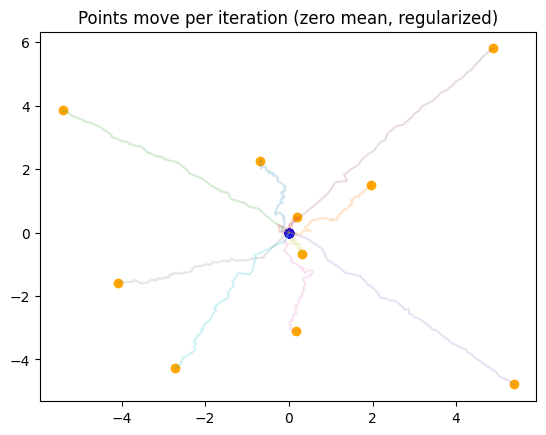

In [29]:
dis = np.array(dis)
for p in range(d0.shape[0]):
    plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
    plt.scatter(dis[-1, p, 0], dis[-1, p, 1], c="orange") # end
    plt.plot(dis[:, p, 0], dis[:, p, 1], alpha=0.2)
plt.title("Points move per iteration (zero mean, regularized)")

Text(0, 0.5, 'MI')

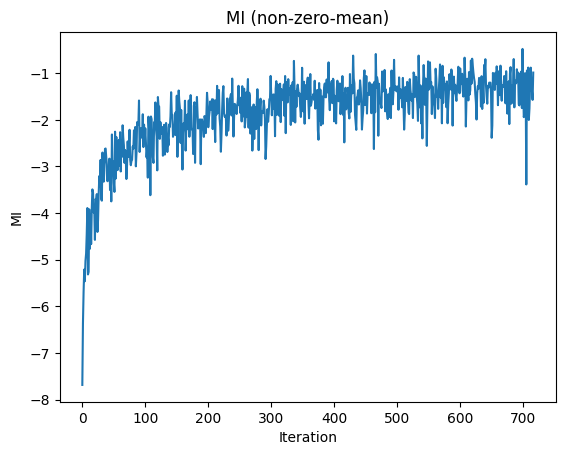

In [14]:
plt.plot(list(range(len(mis))), mis)
plt.title("MI (non-zero-mean)")
plt.xlabel("Iteration")
plt.ylabel("MI")

# Week 3-4

In [35]:
def encode_q_params(q_params): # mean, A to vector
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))
def decode_q_params(encoded_q, dim = 3): # vector to mean, A
    shape = len(encoded_q)
    A_shape = (int(np.sqrt(shape - dim)), int(np.sqrt(shape - dim)))
    mean = encoded_q[0:dim]
    A = encoded_q[dim:shape].reshape(A_shape)
    return mean, A

In [61]:
def log_likelihood(y, theta, d):
    return log_pdf(y, d @ theta, noise * np.eye(len(y)))

In [64]:
def KLD(mean_q, A_q, mean_p, A_p):
    sigma_q = (A_q @ A_q.T)
    sigma_p = (A_p @ A_p.T)
    bar_sigma_q = np.linalg.norm(sigma_q)
    bar_sigma_p = np.linalg.norm(sigma_p)
    k = len(mean_q)
    return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))


In [65]:
def ELBO(d, y, mean, A): # optimizing for mean, A
    zs = np.random.normal(size=(N, len(mean))) # N samples of size d
    likelihood_samples = []
    for z in zs:
        theta = mean + A @ z
        likelihood_samples.append(log_likelihood(y, theta, d))
    return 1/N * np.sum(likelihood_samples, axis=0) - KLD(mean, A, mu_prior, A_prior)


In [86]:
log_pdf = stable_multivariate_gaussian_logpdf
d = np.random.randn(100,2)
A_prior = np.array([[5, -2, 1],
              [-2, 4, -1],
              [1, -1, 3]])
cov_prior = A_prior @ A_prior.T
mu_prior = np.array([7, -4, 1])
noise = 0.8
true_weights = np.array([18, -1, -15])
y = (augment_d(d) @ np.array([true_weights]).T + np.random.randn() * noise).T[0]
mu0 = mu_prior
A0 = A_prior

def callback(encoded_q_params, g):
    qs.append(encoded_q_params)
    return True

def objective_f(encoded_q_params):
    mean, A = decode_q_params(encoded_q_params)
    elbo = ELBO(augment_d(d), y, mean, A)
    elbos.append(elbo._value)
    return -elbo
qs = []
elbos = []
optimizer(encode_q_params((mu0, A0)), grad(objective_f), iters=5e2, callback=callback, rate=1e-3, decay=1e-5)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

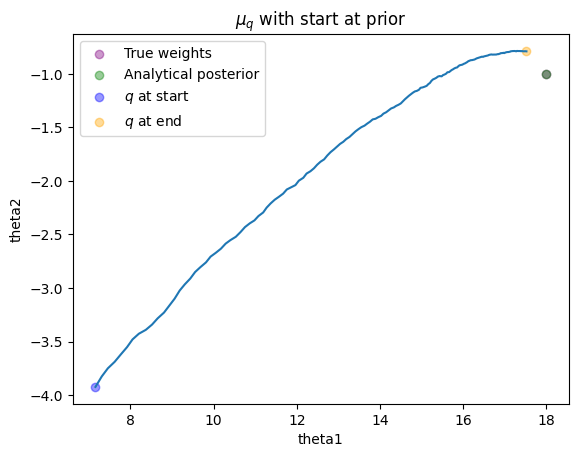

In [90]:
qsa = np.array(qs)
plt.plot(qsa[:, 0], qsa[:,1])
analytical_theta = analytical_posterior_params(augment_d(d), y, mu_prior, cov_prior)
plt.scatter(true_weights[0], true_weights[1], color="purple", label="True weights", alpha=0.4)
plt.scatter(analytical_theta[0][0], analytical_theta[0][1], color="green", label="Analytical posterior", alpha=0.4)
plt.scatter(qsa[0,0], qsa[0,1], color="blue", label="$q$ at start", alpha=0.4)
plt.scatter(qsa[-1,0], qsa[-1,1], color="orange", label="$q$ at end", alpha=0.4)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("$\mu_q$ with start at prior")
plt.legend()

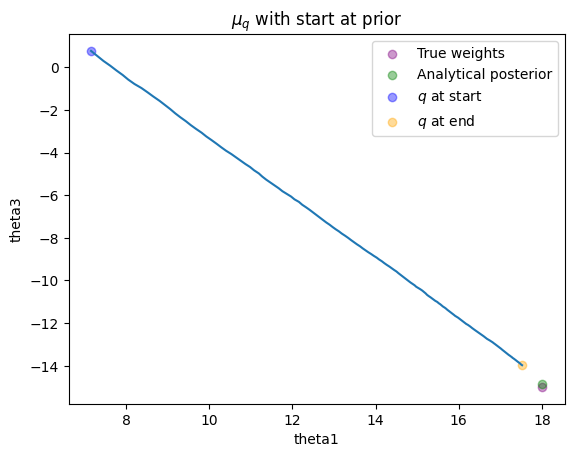

In [91]:
qsa = np.array(qs)
plt.plot(qsa[:, 0], qsa[:,2])
analytical_theta = analytical_posterior_params(augment_d(d), y, mu_prior, cov_prior)
plt.scatter(true_weights[0], true_weights[2], color="purple", label="True weights", alpha=0.4)
plt.scatter(analytical_theta[0][0], analytical_theta[0][2], color="green", label="Analytical posterior", alpha=0.4)
plt.scatter(qsa[0,0], qsa[0,2], color="blue", label="$q$ at start", alpha=0.4)
plt.scatter(qsa[-1,0], qsa[-1,2], color="orange", label="$q$ at end", alpha=0.4)
plt.xlabel("theta1")
plt.ylabel("theta3")
plt.title("$\mu_q$ with start at prior")
plt.legend()

Text(0, 0.5, 'ELBO')

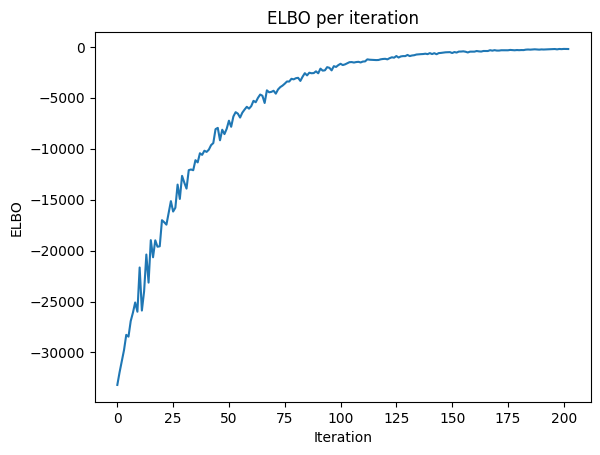

In [89]:
plt.title("ELBO per iteration")
plt.plot(np.arange(0, len(elbos)), elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [82]:
analytical_posterior_params(d,y)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)